In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Library**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd

# **Konfigurasi**

In [ ]:
# Folder ini akan dipecah menjadi 80% Train, 20% Validation
PATH_SOURCE = '/content/drive/MyDrive/Machine Learning/Dataset Sampah/training'

# Folder ini akan menjadi Data Test
PATH_TEST_FINAL = '/content/drive/MyDrive/Machine Learning/Dataset Sampah/validation'

UKURAN_GAMBAR = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

# **Data Generator**

In [ ]:
# Augmentasi untuk Training + Split Validasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Rescale untuk Test
test_datagen = ImageDataGenerator(rescale=1./255)

print("--- Menyiapkan Data Generator ---")

# Training Generator
train_generator = train_datagen.flow_from_directory(
    PATH_SOURCE,
    target_size=UKURAN_GAMBAR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# 2. Validation Generator
validation_generator = train_datagen.flow_from_directory(
    PATH_SOURCE,
    target_size=UKURAN_GAMBAR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    PATH_TEST_FINAL,
    target_size=UKURAN_GAMBAR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Label Kelas
class_labels = list(train_generator.class_indices.keys())
JUMLAH_KELAS = len(class_labels)
print(f"Kelas ditemukan: {class_labels}")

--- Menyiapkan Data Generator ---
Found 1841 images belonging to 3 classes.
Found 459 images belonging to 3 classes.
Found 813 images belonging to 3 classes.
Kelas ditemukan: ['Kaca', 'Kardus', 'Plastik']


# **Arsitektur Model**

In [ ]:
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(UKURAN_GAMBAR[0], UKURAN_GAMBAR[1], 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 4
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Classifier Head
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(JUMLAH_KELAS, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Kompilasi Model**

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,459 (2.00 MB)

 Trainable params: 522,499 (1.99 MB)

 Non-trainable params: 960 (3.75 KB)

# **Training Model**

Model akan disimpan ke: /content/drive/MyDrive/Machine Learning/Models/cnn_scratch_sampah_3split.keras

Mulai melatih model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5335 - loss: 1.0230
Epoch 1: val_accuracy improved from -inf to 0.31920, saving model to /content/drive/MyDrive/Machine Learning/Models/cnn_scratch_sampah_3split.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 544s 9s/step - accuracy: 0.5345 - loss: 1.0211 - val_accuracy: 0.3192 - val_loss: 1.1061
Epoch 2/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.4688 - loss: 1.0733

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.31920 to 0.33929, saving model to /content/drive/MyDrive/Machine Learning/Models/cnn_scratch_sampah_3split.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - accuracy: 0.4688 - loss: 1.0733 - val_accuracy: 0.3393 - val_loss: 1.0995
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.6355 - loss: 0.8183
Epoch 3: val_accuracy improved from 0.33929 to 0.40179, saving model to /content/drive/MyDrive/Machine Learning/Models/cnn_scratch_sampah_3split.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 644ms/step - accuracy: 0.6360 - loss: 0.8179 - val_accuracy: 0.4018 - val_loss: 1.0689
Epoch 4/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.6562 - loss: 0.7048
Epoch 4: val_accuracy did not improve from 0.40179
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.6562 - loss: 0.7048 - val_accuracy: 0.3996 - val_loss: 1.0729
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.6781 - loss: 0.7810
Epoch 5: val_accuracy did not improv

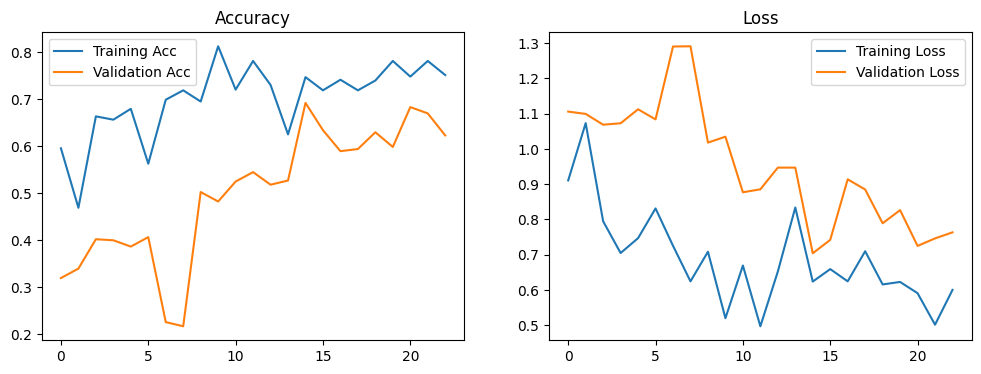

In [ ]:
drive_folder = '/content/drive/MyDrive/Machine Learning/Models'
if not os.path.exists(drive_folder):
    os.makedirs(drive_folder)

filepath = os.path.join(drive_folder, 'cnn_scratch_sampah_3split.keras')
print(f"Model akan disimpan ke: {filepath}")

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

print("\nMulai melatih model...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# **Evaluasi Model**


   EVALUASI PADA DATA TEST (UNSEEN DATA)
26/26 ━━━━━━━━━━━━━━━━━━━━ 265s 11s/step - accuracy: 0.5378 - loss: 0.8895

Akurasi Final pada Test Set: 64.08%
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step


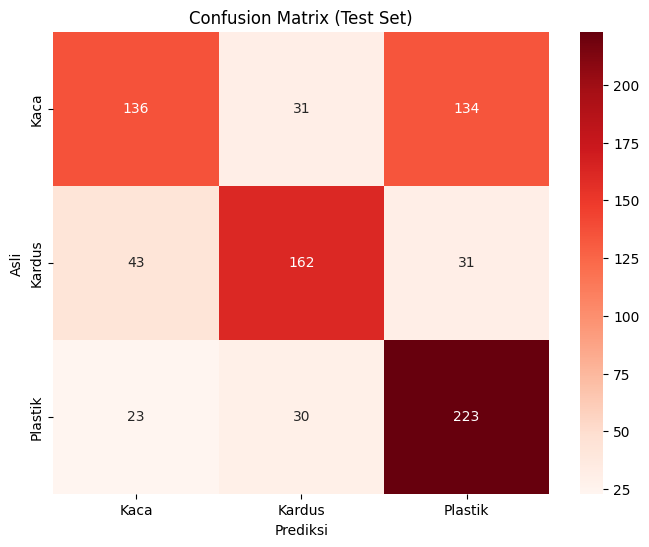


--- Detail Performa per Kelas (Test Set) ---
              precision    recall  f1-score     support
Kaca           0.673267  0.451827  0.540755  301.000000
Kardus         0.726457  0.686441  0.705882  236.000000
Plastik        0.574742  0.807971  0.671687  276.000000
accuracy       0.640836  0.640836  0.640836    0.640836
macro avg      0.658156  0.648746  0.639442  813.000000
weighted avg   0.655260  0.640836  0.633138  813.000000

Menampilkan sampel kesalahan dari Test Set (292 error found)...


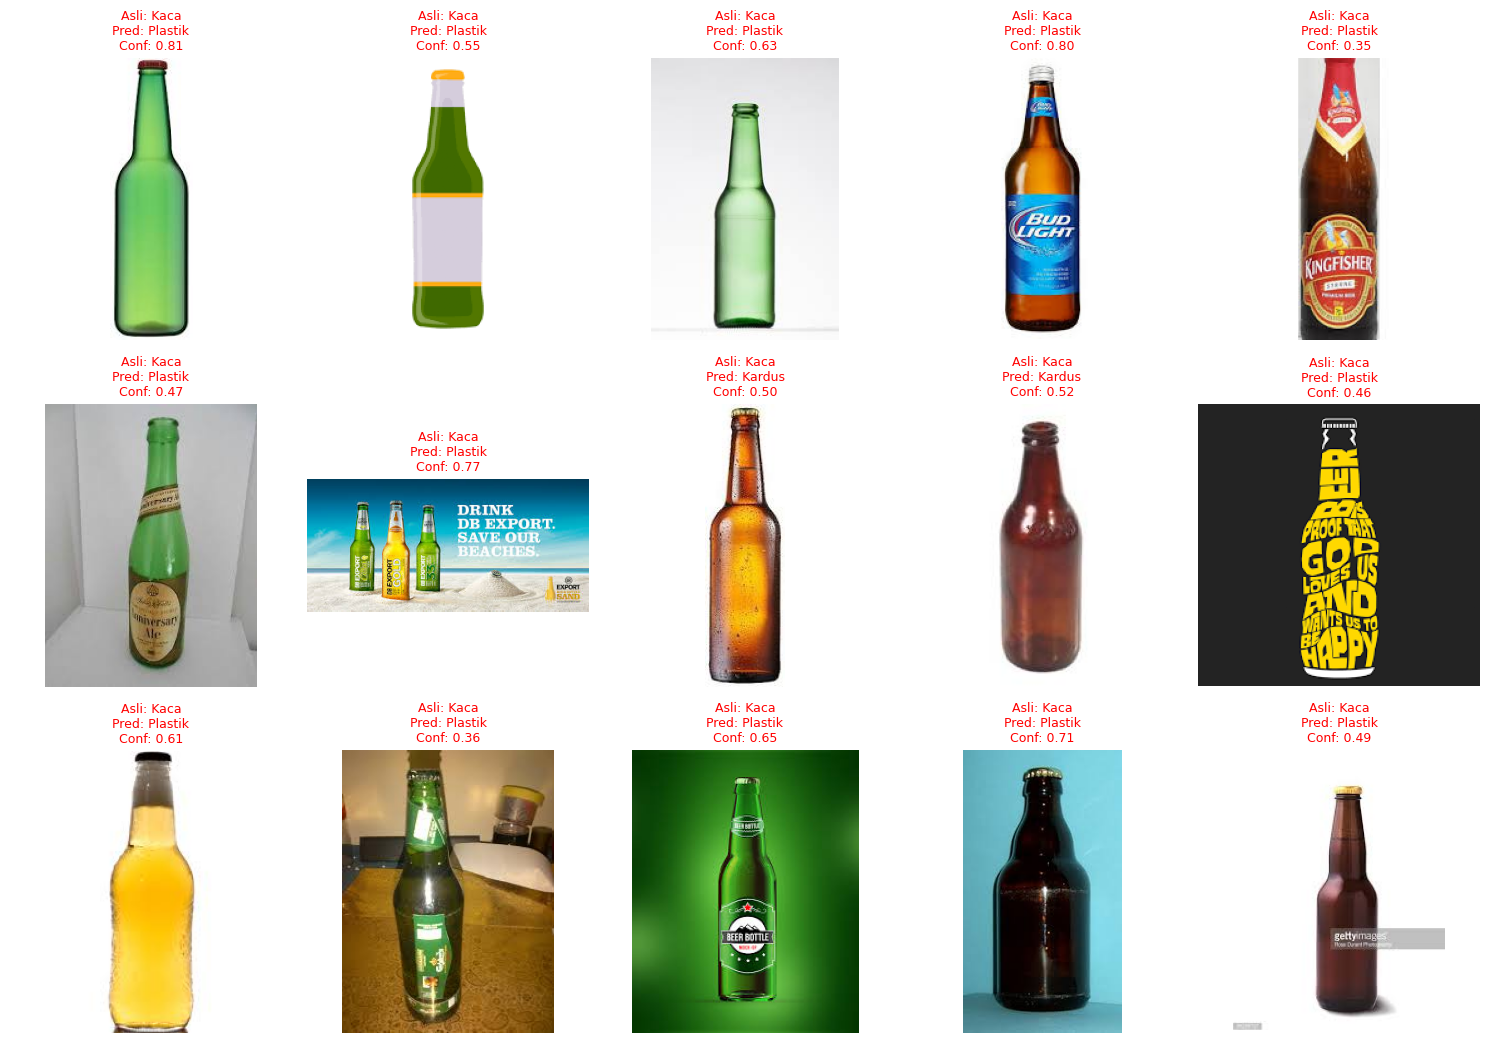

In [ ]:
print("\n" + "="*40)
print("   EVALUASI PADA DATA TEST (UNSEEN DATA)")
print("="*40)

# Load Best Model
best_model = load_model(filepath)

# Evaluasi Score
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"\nAkurasi Final pada Test Set: {test_accuracy*100:.2f}%")

# Confusion Matrix
test_generator.reset()
Y_pred = best_model.predict(test_generator)
y_pred_indices = np.argmax(Y_pred, axis=1)
y_true_indices = test_generator.classes
filenames = test_generator.filenames

# Visualisasi Matrix
cm = confusion_matrix(y_true_indices, y_pred_indices)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Prediksi')
plt.ylabel('Asli')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Classification Report
print("\n--- Detail Performa per Kelas (Test Set) ---")
report_dict = classification_report(y_true_indices, y_pred_indices, target_names=class_labels, output_dict=True)
print(pd.DataFrame(report_dict).transpose())

# Galeri Kesalahan (Hanya dari Test Set)
errors = np.where(y_pred_indices != y_true_indices)[0]
print(f"\nMenampilkan sampel kesalahan dari Test Set ({len(errors)} error found)...")

if len(errors) > 0:
    display_indices = errors[:15]
    rows = (len(display_indices) // 5) + 1
    plt.figure(figsize=(15, 3.5 * rows))

    for i, idx in enumerate(display_indices):
        path = os.path.join(PATH_TEST_FINAL, filenames[idx])
        img = mpimg.imread(path)

        true_lbl = class_labels[y_true_indices[idx]]
        pred_lbl = class_labels[y_pred_indices[idx]]
        conf = Y_pred[idx][y_pred_indices[idx]]

        plt.subplot(rows, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Asli: {true_lbl}\nPred: {pred_lbl}\nConf: {conf:.2f}", color='red', fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("Sempurna! Tidak ada kesalahan pada data test.")